# Adversarial Search: Playing Connect 4

Student Name: Chuanqi Deng

I have used the following AI tools: ChatGPT

I understand that my submission needs to be my own work: CD

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

* Initial state:  Empty 6*7 board
* Actions: Drop a disc into a column which is not full.
* Transition model (result function):  s' = result(a, s). When a player drops a disc into a column, it falls to the lowest available position in that column. If the column is full, the player cannot drop a disc into it, and they must choose a different column.
* Goal state (terminal state and utility): A player's 4 discs formed a horizontal, vertical, or diagonal line. A win has a utility of 1, a loss has a utility of -1, and a draw has a utility of 0.

How big is the state space? Give an estimate and explain it.

For each cell on the game board, there are 3 possibilities: empty, filled with a disc from Player 1, or filled with a disc from Player 2.\
So, for each column, there are 3^6 possible combinations (including the possibility of all cells being empty).\
Since there are 7 columns, we multiply 3^6 by itself 7 times to get the total number of possible game states.\
Therefore, the state space is 3^(6*7) = 3^42.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

At the first level of the tree (initial state), there are 7 possible moves.\
At the second level, assuming all columns are available, there are 6 possible moves for the opponent (one less because the column chosen by the first player is now unavailable).\
At the third level, there are again 7 possible moves for the first player.\
This pattern continues, alternating between 7 and 6 possible moves at each level until the game ends or reaches a terminal state.\
The average branching factor can be estimated as the average of 7 and 6, which is approximately 6.5.\

The maximum number of moves until the game ends is 42 (6 rows x 7 columns).
Using the average branching factor and the depth of 42 moves, we can estimate the size of the game tree as approximately 6.5^42.
Minimax search traverses the complete game tree.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [216]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0, dtype=np.int8)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

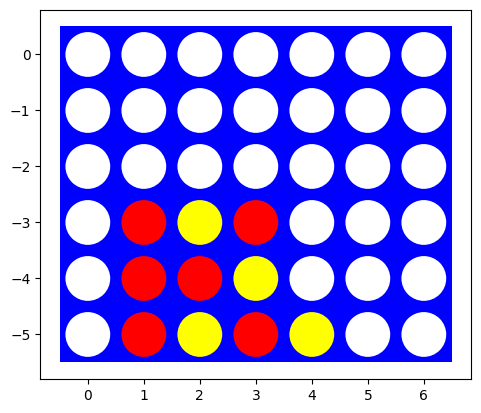

In [217]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 1, -1, 1, 0, 0, 0],
         [0, 1, 1, -1, 0, 0, 0],
         [0, 1,-1, 1, -1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [218]:
# Your code/ answer goes here.
from copy import deepcopy
def actions(s, player = 1):
    """return non-full column index """
    ROW, COL = len(s), len(s[0])
    res = []
    for col in range(COL):
        for row in range(ROW):
            if s[row][col] == 0:
                res.append(col)
                break
    return res
    
    
def result(s, player, a):
    """return state based on given action"""
    s_cpy = deepcopy(s)
    NUM_ROW = len(s)
    for row in range(NUM_ROW-1, -1, -1):
        if s_cpy[row][a] == 0:
            s_cpy[row][a] = player
            break
            
    return s_cpy

def check_win(board):
    """check the board and return one of 1, -1, d (draw), or n (for next move)"""
    
    ROW, COL = len(board), len(board[0])
    
    # columns 
    for col in range(COL):
        cnt = 1
        for row in range(ROW-2, -1, -1):
            if board[row][col] == 0: break
            if board[row][col] == board[row+1][col]:
                cnt += 1
            else:
                cnt = 1
            if cnt == 4:
                return board[row][col]
    
    # rows
    for row in range(ROW):
        cnt = 1
        for col in range(COL-1):
            if board[row][col] == board[row][col+1]:
                cnt += 1
            else:
                cnt = 1
            if board[row][col] != 0 and cnt == 4:
                return board[row][col]
    
    # diagonals
    for start_col in range(3, COL):
        if start_col != COL - 1:
            start_rows = (ROW - 1,)
        else:
            start_rows = range(ROW-1, 2, -1)
            
        for start_row in start_rows:
            row, col = start_row - 1, start_col-1
            cnt = 1
            while row >= 0 and col >= 0:
                if board[row][col] == board[row+1][col+1]:
                    cnt += 1
                else:
                    cnt = 1
                if board[row][col] != 0 and cnt == 4:
                    return board[row][col]
                row -= 1
                col -= 1
                
    # diagonals in another direction
    for start_col in range(0, COL-4+1):
        if start_col != 0:
            start_rows = (ROW - 1,)
        else:
            start_rows = range(ROW-1, 2, -1)
            
        for start_row in start_rows:
            row, col = start_row - 1, start_col + 1
            cnt = 1
            while row >= 0 and col < COL:
                if board[row][col] == board[row+1][col-1]:
                    cnt += 1
                else:
                    cnt = 1
                if board[row][col] != 0 and cnt == 4:
                    return board[row][col]
                row -= 1
                col += 1

    # check if not in terminal state
    for row in range(ROW):
        for col in range(COL):
            if board[row][col] == 0:
                return 'n'
            
    return 'd'
    
def terminal(s):
    """check if s is terminal state"""
    return check_win(s) != 'n'

def utility(s, player=1):
   """check is a state is terminal and return the utility if it is. None means not a terminal mode."""
   goal = check_win(s)        
   if goal == player: return 1
   if goal == 'd': return 0  
   if goal == -1 * player: return -1  # loss is failure
   return None # continue

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [219]:
# Your code/ answer goes here.
def random_player(board, player = 1):
    return np.random.choice(actions(board))

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [239]:
# Your code/ answer goes here.
def switch_player(player, player1, palyer2):
    if player == 1:
        return -1, palyer2
    else:
        return 1, player1

def play(player1, palyer2, N = 1000, bord_size = (6, 7)):
    """Let two agents play each other N times. 1 starts. player1 and palyer2 are agent functions that 
    get the board as the percept and return their next action."""
    results = {1: 0, -1: 0, 0: 0}
    
    for _ in range(N):
        board = empty_board(bord_size)
        player, fun = 1, player1
        
        while not terminal(board):
            a = fun(board, player)
            board = result(board, player, a)
            player, fun = switch_player(player, player1, palyer2)   
            
        win = utility(board)   # returns the 'n' if the game is not done.
        results[win] += 1

    return results

play(random_player, random_player)

{1: 541, -1: 456, 0: 3}

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [231]:
import math
# Your code/ answer goes here.
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, player = 1):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
       
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: 
        if DEBUG >= 2: print(f"     found terminal state. backtracking.")
        return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: 
        if DEBUG >= 2: print(f"     found terminal state. backtacking.")
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, -1 * player, a), player, alpha, beta)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: 
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move


class AlphaBetaAgent:
    def __init__(self, name = "AlphaBetaAgent"):
        self.name = name
        self.state = None
    
    def act(self, board, player):
        move = alpha_beta_search(board, player)['move']
        self.state = result(board, player, move)
        return move
    


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [222]:
board = [[0, 0, 0,-1],
         [1,-1,-1, 1],
         [1,-1,-1,-1],
         [1, 1,-1, 1]]
%time display(alpha_beta_search(board, 1))
print('---------------------------------------')

board = [[0, 0, 0, 0],
         [1,-1,-1, 0],
         [1,-1,-1,-1],
         [1, 1,-1, 1]]
%time display(alpha_beta_search(board, 1))
print('---------------------------------------')

board = [[-1, 0, 0, 0],
         [ 1,-1,-1, 1],
         [ 1,-1,-1,-1],
         [ 1, 1,-1, 1]]
%time display(alpha_beta_search(board, 1))
print('---------------------------------------')

board = [[-1, 1, 1, 0],
         [ 1,-1,-1, 1],
         [ 1,-1,-1,-1],
         [ 1,-1,-1, 1]]
%time display(alpha_beta_search(board, 1))
print('---------------------------------------')

board = [[ 0, 1, 0, 1],
         [ 1,-1,-1, 1],
         [ 1,-1,-1, 1],
         [-1, 1,-1,-1]]
%time display(alpha_beta_search(board, 1))

Number of nodes searched: 8


{'move': 0, 'value': 1}

CPU times: total: 0 ns
Wall time: 1.51 ms
---------------------------------------
Number of nodes searched: 27


{'move': 0, 'value': 1}

CPU times: total: 0 ns
Wall time: 1.01 ms
---------------------------------------
Number of nodes searched: 13


{'move': 2, 'value': 0}

CPU times: total: 0 ns
Wall time: 1 ms
---------------------------------------
Number of nodes searched: 2


{'move': 3, 'value': 0}

CPU times: total: 0 ns
Wall time: 1 ms
---------------------------------------
Number of nodes searched: 5


{'move': 0, 'value': -1}

CPU times: total: 0 ns
Wall time: 1e+03 µs


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [223]:
import time

for size in [(3, 4), (4,4)]:
    board = empty_board(size)
    start_time = time.time()
    alpha_beta_search(board, 1)
    used_time = time.time() - start_time
    print(f"board {size[0]}x{size[1]}: {used_time:.2f} seconds.")

Number of nodes searched: 3697
board 3x4: 0.15 seconds.
Number of nodes searched: 62889
board 4x4: 3.54 seconds.


### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

Here I assign each column a priority. The actions will be sorted based on cooresponding priorities. So, the alpha_beta_search will go to columns with higher priority.

In [229]:
import pandas as pd
priorities = [[0,0,0,0], [1, 0, 1, 1], [1, 1, 0, 1], [0, 1, 0, 1]]
table_data = []
for priority in priorities:
    def actions(s, player = 1):
        """return non-full column index with ordering """
        ROW, COL = len(s), len(s[0])
        res = []
        
        for col in range(COL):
            for row in range(ROW):
                if s[row][col] == 0:
                    res.append((priority[col],col))
                    break
                
        actions = [a for _, a in sorted(res, reverse=True)]
        
        return actions
    start_time = time.time()
    alpha_beta_search(board, 1)
    used_time = time.time() - start_time
    table_data.append([priority, used_time, COUNT])

pd.DataFrame(table_data, columns= ["Stategy", "Time Used(s)", "Node Searched"])

Number of nodes searched: 62889
Number of nodes searched: 62030
Number of nodes searched: 59265
Number of nodes searched: 58290


,Stategy,Time Used(s),Node Searched
0,"[0, 0, 0, 0]",3.331542,62889
1,"[1, 0, 1, 1]",3.438386,62030
2,"[1, 1, 0, 1]",3.322894,59265
3,"[0, 1, 0, 1]",3.306622,58290


### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

For the first few moves, the agent can only explore those actions with higher priority.
Or, use a fixed pattern that have higher chance to win the game to place the discs.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [244]:
def actions(s, player = 1):
        """return non-full column index with ordering """
        ROW, COL = len(s), len(s[0])
        res = []
        priority = [0 if i % 2 == 0 else 1  for i in range(COL)]
        for col in range(COL):
            for row in range(ROW):
                if s[row][col] == 0:
                    res.append((priority[col],col))
                    break
                
        actions = [a for _, a in sorted(res, reverse=True)]
        
        return actions
    
ab_agent = AlphaBetaAgent()
DEBUG = 0
play(random_player, ab_agent.act, 20, (4, 4))

{1: 0, -1: 14, 0: 6}

According to the result, Alpha-Beta Agent wins most of the time and the random agent never wins.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [336]:
def is_valid(board, row, col, ROW, COL, check_below_4th):
    if row < 0 or row >= ROW or col < 0 or col >= COL\
        or board[row][col] != 0:
        return False
    if not check_below_4th:
        return True
    if row == ROW - 1:
        return True
    if board[row+1][col] == 0:
        return False
    return True
    
    
def eval_fun(board, player = 1, check_below_4th = True):
    """heuristic for utility of state. Returns score for a node:
    1. For terminal states it returns the utility. 
    2. For non-terminal states, it calculates a weighted linear function using features of the state. 
    The features we look at are 3 in a row/col/diagonal where the 4th square is empty. We assume that
    the more of these positions we have, the higher the chance of winning.
    We need to be careful that the utility of the heuristic stays between [-1,1]. 
    Note that the largest possible number of these positions is smaller than ROW*COL. I weigh the count by 1/(ROW*COL), 
    guaranteeing that is in the needed range.
    
    Function Returns: heuistic value, terminal?"""
    
    # terminal state?
    u = utility(board, player)
    if u is not None: return u, True
      
    score = 0
    ROW, COL = len(board), len(board[0])
    score_one = 1/(ROW*COL)
    
    # columns 
    for col in range(COL):
        cnt = 1
        for row in range(ROW-2, -1, -1):
            if board[row][col] == 0: break
            if board[row][col] == board[row+1][col]:
                cnt += 1
            else:
                cnt = 1
            if cnt == 3 and row-1>=0 and board[row-1][col] == 0:
                score += board[row][col] * score_one 
    
    # rows
    for row in range(ROW):
        cnt = 1
        for col in range(COL-1):
            if board[row][col] == board[row][col+1]:
                cnt += 1
            else:
                cnt = 1
            if board[row][col] != 0 and cnt == 3 and \
                (is_valid(board, row, col-2, ROW, COL, check_below_4th) or is_valid(board, row, col+2, ROW, COL, check_below_4th)):
                score += board[row][col] * score_one 
    
    # diagonals \ 
    for start_col in range(3, COL):
        if start_col != COL - 1:
            start_rows = (ROW - 1,)
        else:
            start_rows = range(ROW-1, 2, -1)
            
        for start_row in start_rows:
            row, col = start_row - 1, start_col-1
            cnt = 1
            while row >= 0 and col >= 0:
                if board[row][col] == board[row+1][col+1]:
                    cnt += 1
                else:
                    cnt = 1
                if board[row][col] != 0 and cnt == 3 and \
                    (is_valid(board, row+3, col+3, ROW, COL, check_below_4th) or is_valid(board, row-1, col-1, ROW, COL, check_below_4th)):
                    score += board[row][col] * score_one 
                row -= 1
                col -= 1
                
    # diagonals in another direction /
    for start_col in range(0, COL-4+1):
        if start_col != 0:
            start_rows = (ROW - 1,)
        else:
            start_rows = range(ROW-1, 2, -1)
            
        for start_row in start_rows:
            row, col = start_row - 1, start_col + 1
            cnt = 1
            while row >= 0 and col < COL:
                if board[row][col] == board[row+1][col-1]:
                    cnt += 1
                else:
                    cnt = 1
                if board[row][col] != 0 and cnt == 3 and \
                    (is_valid(board, row+3, col-3, ROW, COL, check_below_4th) or is_valid(board, row-1, col+1, ROW, COL, check_below_4th)):
                    score += board[row][col] * score_one 
                row -= 1
                col += 1
    
    return score, False

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [335]:
# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, cutoff = None, check_below_4th = True, player = 1):
    """start the search. cutoff = None is minimax search with alpha-beta pruning."""
    global DEBUG, COUNT
    COUNT = 0

    value, move = max_value_ab(board, player, -math.inf, +math.inf, 0, cutoff, check_below_4th)
    
    if DEBUG >= 1: print(f"Number of nodes searched (cutoff = {cutoff}): {COUNT}") 
    
    return {"move": move, "value": value}

def max_value_ab(state, player, alpha, beta, depth, cutoff, check_below_4th = True):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player, check_below_4th)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta, depth + 1, cutoff, check_below_4th)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta, depth, cutoff, check_below_4th = True):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player, check_below_4th)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, -1 * player, a), player, alpha, beta, depth + 1, cutoff, check_below_4th)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

class HeuristicAgent:
    def __init__(self, cutoff = 8, check_below_4th = True, name = "HeuristicAgent"):
        self.name = name
        self.state = None
        self.cutoff = cutoff
        self.check_below_4th = check_below_4th
    
    def act(self, board, player):
        move = alpha_beta_search(board, self.cutoff , player)['move']
        self.state = result(board, player, move)
        return move

In [303]:
board = [[0, 0, 0, 0],
         [0, 1, 1, 1],
         [1, 1,-1,-1],
         [1, 1,-1, 1]]
%time display(alpha_beta_search(board, 10, 1))
board = [[0, 0, 0, 0],
         [0, 1, 1, 1],
         [1, 1,-1,-1],
         [1, 1,-1, 1]]
%time display(alpha_beta_search(board, 5, 1))

Number of nodes searched (cutoff = 10): 8


{'move': 3, 'value': 1}

CPU times: total: 0 ns
Wall time: 2 ms
Number of nodes searched (cutoff = 5): 8


{'move': 3, 'value': 1}

CPU times: total: 0 ns
Wall time: 2.01 ms


Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [304]:
board = [[0, 0, 0,-1],
         [1,-1,-1, 1],
         [1,-1,-1,-1],
         [1, 1,-1, 1]]
%time display(alpha_beta_search(board, 10, 1))
print('---------------------------------------')

board = [[0, 0, 0, 0],
         [1,-1,-1, 0],
         [1,-1,-1,-1],
         [1, 1,-1, 1]]
%time display(alpha_beta_search(board, 10, 1))
print('---------------------------------------')

board = [[-1, 0, 0, 0],
         [ 1,-1,-1, 1],
         [ 1,-1,-1,-1],
         [ 1, 1,-1, 1]]
%time display(alpha_beta_search(board, 10, 1))
print('---------------------------------------')

board = [[-1, 1, 1, 0],
         [ 1,-1,-1, 1],
         [ 1,-1,-1,-1],
         [ 1,-1,-1, 1]]
%time display(alpha_beta_search(board, 10, 1))
print('---------------------------------------')

board = [[ 0, 1, 0, 1],
         [ 1,-1,-1, 1],
         [ 1,-1,-1, 1],
         [-1, 1,-1,-1]]
%time display(alpha_beta_search(board, 10, 1))

Number of nodes searched (cutoff = 10): 11


{'move': 0, 'value': 1}

CPU times: total: 0 ns
Wall time: 1.05 ms
---------------------------------------
Number of nodes searched (cutoff = 10): 71


{'move': 0, 'value': 1}

CPU times: total: 0 ns
Wall time: 3.32 ms
---------------------------------------
Number of nodes searched (cutoff = 10): 14


{'move': 2, 'value': 0}

CPU times: total: 0 ns
Wall time: 1.51 ms
---------------------------------------
Number of nodes searched (cutoff = 10): 2


{'move': 3, 'value': 0}

CPU times: total: 0 ns
Wall time: 1.01 ms
---------------------------------------
Number of nodes searched (cutoff = 10): 5


{'move': 2, 'value': -1}

CPU times: total: 0 ns
Wall time: 1.51 ms


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [314]:
import time

for size in [(4, 5), (5, 6), (6, 7)]:
    board = empty_board(size)
    start_time = time.time()
    alpha_beta_search(board, 8, 1)
    used_time = time.time() - start_time
    print(f"board {size[0]}x{size[1]}: {used_time:.2f} seconds.")

Number of nodes searched (cutoff = 8): 2816
board 4x5: 0.43 seconds.
Number of nodes searched (cutoff = 8): 8916
board 5x6: 1.40 seconds.
Number of nodes searched (cutoff = 8): 15369
board 6x7: 3.58 seconds.


### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [370]:
DEBUG = 0

# differenet evaluation function controlled by the second parameter.
heuristic_agent1 = HeuristicAgent(8, True)
heuristic_agent2 = HeuristicAgent(2, False)
play(heuristic_agent1.act, random_player, 1, (5, 5))

{1: 1, -1: 0, 0: 0}

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [376]:
def playout(state, action, player = 1):
    """Perfrom a random playout starting with the given action on the fiven board 
    and return the utility of the finished game."""
    state = result(state, player, action)
    current_player = -1 * player
    
    while(True):
        # reached terminal state?
        u = utility(state, player)
        if u is not None: return(u)
        
        # we use a random playout policy
        a = np.random.choice(actions(state))
        state = result(state, current_player, a)
        #print(state)
        
        # switch between players
        current_player = -1 * current_player


# Playout for action 0 (top-left corner)
board = empty_board()
print(playout(board, 0))
print(playout(board, 0))
print(playout(board, 0))
print(playout(board, 0))
print(playout(board, 0))

1
-1
1
-1
1


In [381]:
def playouts(board, action, player = 1, N = 100):
    """Perform N playouts following the given action for the given board."""
    return [ playout(board, action, player) for i in range(N) ]

u = playouts(board, 3)
print("Playout results:", u)

print(f"mean utility: {np.mean(u)}")

p_win = sum(np.array(u) == +1)/len(u)
p_loss = sum(np.array(u) == -1)/len(u)
p_draw = sum(np.array(u) == 0)/len(u)
print(f"win probability: {p_win}")
print(f"loss probability: {p_loss}")
print(f"draw probability: {p_draw}")

Playout results: [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1]
mean utility: 0.36
win probability: 0.68
loss probability: 0.32
draw probability: 0.0


In [382]:
DEBUG = 1


def pmcs(board, N = 100, player = 1):
    """Pure Monte Carlo Search. Returns the action that has the largest average utility.
    The N playouts are evenly divided between the possible actions."""
    global DEBUG
    
    acts = actions(board)
    n = math.floor(N/len(acts))
    if DEBUG >= 1: print(f"Actions: {acts} ({N} total playouts = {n} playouts per action)")
    
    ps = { i : np.mean(playouts(board, i, player, N = n)) for i in acts }
    if DEBUG >= 1: display(ps)
        
    action = max(ps, key=ps.get)
    return action

board = empty_board()
display(board)
%time print(pmcs(board))

print()
print("10000 playouts give a better utility estimate.")
%time print(pmcs(board, N = 10000))

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int8)

Actions: [5, 3, 1, 6, 4, 2, 0] (100 total playouts = 14 playouts per action)


{5: 0.0,
 3: 0.2857142857142857,
 1: 0.14285714285714285,
 6: 0.14285714285714285,
 4: 0.7142857142857143,
 2: 0.2857142857142857,
 0: 0.14285714285714285}

4
CPU times: total: 31.2 ms
Wall time: 324 ms

10000 playouts give a better utility estimate.
Actions: [5, 3, 1, 6, 4, 2, 0] (10000 total playouts = 1428 playouts per action)


{5: 0.12394957983193278,
 3: 0.3067226890756303,
 1: 0.055322128851540614,
 6: 0.03571428571428571,
 4: 0.14775910364145659,
 2: 0.1211484593837535,
 0: -0.0273109243697479}

3
CPU times: total: 6.22 s
Wall time: 31.2 s


In [384]:
board = [[0, 0, 0,-1],
         [1,-1,-1, 1],
         [1,-1,-1,-1],
         [1, 1,-1, 1]]
%time display(pmcs(board, 100, 1))
print('--------------------------------------------------------------')

board = [[0, 0, 0, 0],
         [1,-1,-1, 0],
         [1,-1,-1,-1],
         [1, 1,-1, 1]]
%time display(pmcs(board, 100, 1))
print('--------------------------------------------------------------')

board = [[-1, 0, 0, 0],
         [ 1,-1,-1, 1],
         [ 1,-1,-1,-1],
         [ 1, 1,-1, 1]]
%time display(pmcs(board, 100, 1))
print('--------------------------------------------------------------')

board = [[-1, 1, 1, 0],
         [ 1,-1,-1, 1],
         [ 1,-1,-1,-1],
         [ 1,-1,-1, 1]]
%time display(pmcs(board, 100, 1))
print('--------------------------------------------------------------')

board = [[ 0, 1, 0, 1],
         [ 1,-1,-1, 1],
         [ 1,-1,-1, 1],
         [-1, 1,-1,-1]]
%time display(pmcs(board, 100, 1))

Actions: [1, 2, 0] (100 total playouts = 33 playouts per action)


{1: -0.45454545454545453, 2: 0.3939393939393939, 0: 1.0}

0

CPU times: total: 0 ns
Wall time: 7.69 ms
--------------------------------------------------------------
Actions: [3, 1, 2, 0] (100 total playouts = 25 playouts per action)


{3: -0.24, 1: -0.64, 2: 0.52, 0: 1.0}

0

CPU times: total: 0 ns
Wall time: 9.54 ms
--------------------------------------------------------------
Actions: [3, 1, 2] (100 total playouts = 33 playouts per action)


{3: -0.48484848484848486, 1: -0.45454545454545453, 2: 0.0}

2

CPU times: total: 0 ns
Wall time: 9.52 ms
--------------------------------------------------------------
Actions: [3] (100 total playouts = 100 playouts per action)


{3: 0.0}

3

CPU times: total: 0 ns
Wall time: 4 ms
--------------------------------------------------------------
Actions: [2, 0] (100 total playouts = 50 playouts per action)


{2: -1.0, 0: -1.0}

2

CPU times: total: 0 ns
Wall time: 5.51 ms


### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [387]:
# Your code/ answer goes here.
board = empty_board()
pmcs(board, 5000, 1)

Actions: [5, 3, 1, 6, 4, 2, 0] (5000 total playouts = 714 playouts per action)


{5: 0.07983193277310924,
 3: 0.2689075630252101,
 1: 0.08403361344537816,
 6: 0.0056022408963585435,
 4: 0.14145658263305322,
 2: 0.17647058823529413,
 0: -0.00980392156862745}

3

Based on the seach above, the best first move is 3. This is in the middle and it makes sense because the player can expand to both left and right. Also, this move makes the other player difficult to defense.